In [6]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 78.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.6 MB/s eta 0:00:00:00:01


In [39]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
from pprint import pprint
from PIL import Image
import seaborn as sns
import transformers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.13.1+cu117 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=14930MB, multi_processor_count=40)


In [21]:
CLASSES_DICT = {
    0: 'Apple Braeburn', 1: 'Apple Crimson Snow', 2: 'Apple Golden 1', 3: 'Apple Golden 2', 4: 'Apple Golden 3',
    5: 'Apple Granny Smith', 6: 'Apple Pink Lady', 7: 'Apple Red 1', 8: 'Apple Red 2', 9: 'Apple Red 3',
    10: 'Apple Red Delicious', 11: 'Apple Red Yellow 1', 12: 'Apple Red Yellow 2', 13: 'Apricot', 14: 'Avocado',
    15: 'Avocado ripe', 16: 'Banana', 17: 'Banana Lady Finger', 18: 'Banana Red', 19: 'Beef', 20: 'Beetroot',
    21: 'Blueberry', 22: 'Butter', 23: 'Cactus fruit', 24: 'Cantaloupe 1', 25: 'Cantaloupe 2', 26: 'Carambula',
    27: 'Cauliflower', 28: 'Cherry 1', 29: 'Cherry 2', 30: 'Cherry Rainier', 31: 'Cherry Wax Black',
    32: 'Cherry Wax Red', 33: 'Cherry Wax Yellow', 34: 'Chestnut', 35: 'Chicken', 36: 'Clementine', 37: 'Cocos',
    38: 'Corn', 39: 'Corn Husk', 40: 'Cucumber Ripe', 41: 'Cucumber Ripe 2', 42: 'Dates', 43: 'Egg', 44: 'Eggplant',
    45: 'Eggs', 46: 'Fig', 47: 'Flour', 48: 'Ginger Root', 49: 'Granadilla', 50: 'Grape Blue', 51: 'Grape Pink',
    52: 'Grape White', 53: 'Grape White 2', 54: 'Grape White 3', 55: 'Grape White 4', 56: 'Grapefruit Pink',
    57: 'Grapefruit White', 58: 'Guava', 59: 'Hazelnut', 60: 'Huckleberry', 61: 'Kaki', 62: 'Kiwi', 63: 'Kohlrabi',
    64: 'Kumquats', 65: 'Lamb', 66: 'Lemon', 67: 'Lemon Meyer', 68: 'Limes', 69: 'Lychee', 70: 'Mandarine',
    71: 'Mango', 72: 'Mango Red', 73: 'Mangostan', 74: 'Maracuja', 75: 'Melon Piel de Sapo', 76: 'Milk',
    77: 'Mulberry', 78: 'Nectarine', 79: 'Nectarine Flat', 80: 'Nut Forest', 81: 'Nut Pecan', 82: 'Onion Red',
    83: 'Onion Red Peeled', 84: 'Onion White', 85: 'Orange', 86: 'Papaya', 87: 'Passion Fruit', 88: 'Pasta',
    89: 'Peach', 90: 'Peach 2', 91: 'Peach Flat', 92: 'Pear', 93: 'Pear 2', 94: 'Pear Abate', 95: 'Pear Forelle',
    96: 'Pear Kaiser', 97: 'Pear Monster', 98: 'Pear Red', 99: 'Pear Stone', 100: 'Pear Williams', 101: 'Pepino',
    102: 'Pepper Green', 103: 'Pepper Orange', 104: 'Pepper Red', 105: 'Pepper Yellow', 106: 'Physalis',
    107: 'Physalis with Husk', 108: 'Pineapple', 109: 'Pineapple Mini', 110: 'Pitahaya Red', 111: 'Plum',
    112: 'Plum 2', 113: 'Plum 3', 114: 'Pomegranate', 115: 'Pomelo Sweetie', 116: 'Pork', 117: 'Potato Red',
    118: 'Potato Red Washed', 119: 'Potato Sweet', 120: 'Potato White', 121: 'Quince', 122: 'Rambutan',
    123: 'Raspberry', 124: 'Redcurrant', 125: 'Rice', 126: 'Salak', 127: 'Salmon', 128: 'Strawberry',
    129: 'Strawberry Wedge', 130: 'Tamarillo', 131: 'Tangelo', 132: 'Tomato 1', 133: 'Tomato 2', 134: 'Tomato 3',
    135: 'Tomato 4', 136: 'Tomato Cherry Red', 137: 'Tomato Heart', 138: 'Tomato Maroon', 139: 'Tomato Yellow',
    140: 'Tomato not Ripened', 141: 'Walnut', 142: 'Watermelon'
}

NUM_CLASSES = len(CLASSES_DICT.keys())
print(NUM_CLASSES)

143


In [43]:
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
from transformers import DeiTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class DeiTForImageClassification(nn.Module):
    def __init__(self, num_labels=NUM_CLASSES):
        super(DeiTForImageClassification, self).__init__()
        self.deit = DeiTModel.from_pretrained('facebook/deit-base-distilled-patch16-224')

        self.classifier = nn.Sequential(
            nn.Linear(self.deit.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(256, NUM_CLASSES)
        )
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.deit(pixel_values=pixel_values)
        logits = self.classifier(outputs.last_hidden_state[:,0])
        return logits

In [12]:
# Load the pre-trained weights from the .pth file
model_state_dict = torch.load('./best_additional_deit.pth')

# Instantiate the model and load the state dict
model = DeiTForImageClassification()
model.load_state_dict(model_state_dict)

print(model)

# Ensure the model is in evaluation mode
model.eval()

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0): DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_feature

DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0): DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_feature

In [50]:
!ls ./segmented_images/11074

0.png	15.png	21.png	29.png	31.png	36.png	5.png	65.png	72.png	74.png
14.png	2.png	22.png	3.png	33.png	4.png	60.png	69.png	73.png	9.png


In [44]:
def predict_image_class(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transformations(image).unsqueeze(0)  # Add batch dimension

    # Pass the image through the model
    with torch.no_grad():
        logits = model(image_tensor)

    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=1)

    # Get the predicted class index
    predicted_class_index = torch.argmax(probabilities, dim=1).item()

    # Map the predicted class index to the corresponding label
    predicted_label = CLASSES_DICT[predicted_class_index]

    # Display the image along with the predicted label
    plt.imshow(image)
    plt.title("Predicted Label: " + predicted_label)
    plt.axis('off')
    plt.show()

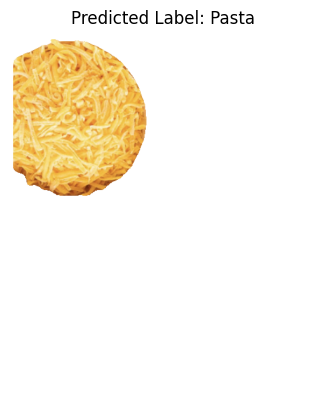

In [45]:
# Single ingredient test
predict_image_class('./segmented_images/11074/0.png')

In [46]:
# Define the function to predict labels for all images in a folder
def predict_images_in_folder(folder_path):
    predicted_labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            # Construct the full path to the image file
            image_path = os.path.join(folder_path, filename)
            # Load and preprocess the image
            image = Image.open(image_path).convert('RGB')
            image_tensor = transformations(image).unsqueeze(0)  # Add batch dimension

            # Pass the image through the model
            with torch.no_grad():
                logits = model(image_tensor)

            # Apply softmax to get probabilities
            probabilities = torch.softmax(logits, dim=1)

            # Get the predicted class index
            predicted_class_index = torch.argmax(probabilities, dim=1).item()

            # Map the predicted class index to the corresponding label
            predicted_label = CLASSES_DICT[predicted_class_index]
            predicted_labels.append(predicted_label)

            # Display the image along with the predicted label
            '''
            plt.imshow(image)
            plt.title("Predicted Label: " + predicted_label)
            plt.axis('off')
            plt.show()
            '''

    return predicted_labels

In [47]:
# Define the function to iterate over subfolders and collect predicted labels
def collect_predicted_labels_in_subfolders(main_folder):
    predicted_labels_dict = {}
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        if os.path.isdir(subfolder_path):
            # Call the function to predict labels for images in the subfolder
            predicted_labels = predict_images_in_folder(subfolder_path)
            # Store the predicted labels in a dictionary
            predicted_labels_dict[subfolder] = predicted_labels
    return predicted_labels_dict

In [48]:
main_folder = './segmented_images'  # Main folder that contains subfolders
predicted_labels_dict = collect_predicted_labels_in_subfolders(main_folder) # Map all subfolders to a list of all identified foods

In [49]:
# Pretty print the key-value mappings
pprint(predicted_labels_dict)

{'1': ['Egg',
       'Egg',
       'Egg',
       'Pasta',
       'Egg',
       'Egg',
       'Pasta',
       'Corn',
       'Corn',
       'Corn',
       'Egg',
       'Egg',
       'Pasta',
       'Corn',
       'Corn',
       'Egg',
       'Egg',
       'Pasta',
       'Pasta',
       'Egg'],
 '10694': ['Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Rice',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Egg',
           'Fig',
           'Egg'],
 '10853': ['Egg',
           'Egg',
           'Egg',
           'Egg',
           'Carambula',
           'Egg',
           'Milk',
           'Egg',
           'Egg',
           'Pear Williams',
           'Milk',
           'Dates',
           'Milk',
           'Pear Williams',
           'Egg',
           'Egg',
           'Egg',
     